### 1.2.1: EDA : Advance Feature Selection 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sn 
import numpy as np 
import nltk 
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from fuzzywuzzy import fuzz
from bs4 import BeautifulSoup
import distance
from wordcloud import WordCloud, STOPWORDS
import os

C:\Users\welcome\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
df=pd.read_csv('df_fe_without_preprocessing_train.csv',encoding='latin-1')
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20,0.200000,2,0


## 3.4 Preprocessing of text.

- Preprocessing :
     -  Removing HTMLTags 
     -  Removing Puctuations 
     -  Performing Stemming 
     -  Removing Stopwords 
     -  Expanding Contraction Etc

In [3]:
stop_words= stopwords.words('english')

def preprocess(x):
    x=str(x).lower()
    x=x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x=re.sub(r'([0-9]+)000000', r'\1m', x)
    x=re.sub(r'([0-9]+)000' , r'\1k' , x)
    
    porter=PorterStemmer()
    pattern=re.compile('\W')
    
    #removing punctuation
    if type(x)==type(''):
        x=re.sub(pattern,' ', x)
        
     #removing HTML tags   
    if type(x)==type(''):
        x=porter.stem(x)
        example=BeautifulSoup(x)
        x=example.get_text()
        
    return x

### 3.5 Advance Feature Selection   ( NLP and FUZZY Features )


- Defination :
   -   Token: You get token by splittng sentance a space .
   -   Stop_words : Stop words as per nltk .
   -   Word : A Token which is not a Stop_word .
   
- Features :
   -   cwc_min : Ratio of common_word_count to min length of word count of Q1 and Q2 .
   -   cwc_max : Ratio of common_word_count to max length of word count of Q1 and Q2 .
   -   csc_min : Ratio of common_stop_count to min length of stop count of Q1 and Q2 .
   -   csc_max : Ratio of common_stop_count to max length of stop count of Q1 and Q2 .
   -   ctc_min : Ratio of common_token_count to min length of token count of Q1 and Q2.
   -   ctc_max : Ratio of common_token_count to max length of token count of Q1 and Q2 .
   -   last_word_eq : Check if last word of both questions is equal or not .
   -   first_word_eq : Check if first word of both questions is equal or not .
   -   abs_len_diff : Absolute length diff of q1 and q2 .
   -   mean_len : Mean length of both question 
   -   Fuzz_ratio: https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
   -   Fuzz_partial_ratio : https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
   -   Token_sort_ratio : https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
   -   Token_set_ratio : https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
   -   Longest_substr_ratio : Ratio of length of Longest common substring to miin length of token count of Q1 and Q2.
   
   

In [4]:
safe_dev= 0.001

def get_token_features (q1,q2):
    token_features=[0]*10
    
    q1_tokens= q1.split()
    q2_tokens= q2.split()
    
    if len(q1_tokens)==0 or len(q2_tokens)==0:
        return token_features
    else:
        q1_words= set([w for w in q1_tokens if w not in stop_words])
        q2_words= set([w for w in q2_tokens if w not in stop_words])   
    
        q1_stopwords= set([w for w in q1_tokens if w in stop_words]) 
        q2_stopwords= set([w for w in q2_tokens if w in stop_words]) 
    
        common_word_count = len(q1_words.intersection(q2_words))
        common_stop_count = len(q1_stopwords.intersection(q2_stopwords))
        common_token_count= len(set(q1_tokens) & (set(q2_tokens)))
    
    
        token_features[0]= common_word_count/  (min(len(q1_words),len(q2_words))+ safe_dev )
        token_features[1]= common_word_count/  (max(len(q1_words),len(q2_words))+ safe_dev )
        token_features[2]= common_stop_count/  (min(len(q1_stopwords),len(q2_stopwords))+ safe_dev )
        token_features[3]= common_stop_count/  (max(len(q1_stopwords),len(q2_stopwords))+ safe_dev )
        token_features[4]= common_token_count/   (min(len(q1_tokens),len(q2_tokens))+ safe_dev )
        token_features[5]= common_token_count/   (max(len(q1_tokens),len(q2_tokens))+ safe_dev )
                                            
        token_features[6]= int(q1_tokens[0]==q2_tokens[0])
                        
        token_features[7]=  int(q1_tokens[-1]==q2_tokens[-1])
                                            
        token_features[8]= abs(len(q1_tokens)- len(q2_tokens))
                                            
        token_features[9]= (len(q1_tokens)+ len(q2_tokens))/2
                                            
        return token_features 
                                            
def longest_substring_ratio(a,b):
    strs= list(distance.lcsubstrings(a, b))
    if len(strs)==0:
        return 0
    else:
        return len(strs[0])/  (min(len(a), len(b)) +1)

In [5]:
def extract_features(df):
   
    df['question1']= df['question1'].fillna('').apply(preprocess)
    df['question2']= df['question2'].fillna('').apply(preprocess)
    
    
    print('token features.......')
    
    token_features =df.apply( lambda x : get_token_features(x['question1'],x['question2']), axis=1)
    
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
    
    print('fuzzy features ....... ')
    
    
    df['token_set_ratio'] = df.apply(lambda x : fuzz.token_set_ratio(x["question1"],x["question2"]), axis=1)
    
    df['token_sort_ratio'] = df.apply(lambda x : fuzz.token_sort_ratio(x["question1"],x["question2"]), axis=1)
    
    df['token_fuzz_ratio'] = df.apply(lambda x : fuzz.QRatio(x["question1"],x["question2"]), axis=1)
    
    df['token_fuzz_partial_ratio'] = df.apply(lambda x : fuzz.partial_ratio(x["question1"],x["question2"]), axis=1)
    
    
    df['longest_substr_ratio']= df.apply(lambda x:longest_substring_ratio(x["question1"],x["question2"]), axis=1)
    
    
    return df

In [6]:
df=extract_features(df)

df.head(2)

token features.......
fuzzy features ....... 


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,token_fuzz_ratio,token_fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785658,1,0,2,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,1,1,51,88,...,0.466636,1,0,5,12.5,86,63,66,75,0.596154


In [7]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1').fillna('')
else:
    print("Extracting features for train:")
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

Extracting features for train:


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,token_fuzz_ratio,token_fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785658,1,0,2,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,1,1,51,88,...,0.466636,1,0,5,12.5,86,63,66,75,0.596154


## 3.5.1 Analysis of Extracted Features 

### 3.5.1.1 Plotting word cloud 

* Creating word cloud for duplicate and non duplicate features .
* We can observe most occuring words .

In [8]:
df_duplicate= df[df['is_duplicate']==1]
df_nonduplicate= df[df['is_duplicate']==0]

p=np.dstack([df_duplicate['question1'],df_duplicate['question2']]).flatten()
n=np.dstack([df_nonduplicate['question1'],df_nonduplicate['question2']]).flatten()

print('no of datapoints in class 1 (dulicate paris) : ', len(p))
print('no of datapoints in class 0 (nonduplicate pairs: )', len(n))

np.savetxt('train_p.txt', p , delimiter=' ', fmt= '%s')
np.savetxt('train_n.txt', n , delimiter=' ', fmt= '%s')


no of datapoints in class 1 (dulicate paris) :  111718
no of datapoints in class 0 (nonduplicate pairs: ) 188282


In [9]:
d=os.path.dirname('.')

textp_w = open(os.path.join(d,'train_p.txt')).read()
textn_w = open(os.path.join(d,'train_n.txt')).read()

stopwords= set(STOPWORDS)



print('total no of words in duplicate question : ', len(textp_w))
print('total no of words in non duplicate question : ', len(textn_w))




total no of words in duplicate question :  6027119
total no of words in non duplicate question :  12242657


* Word Cloud generated from duplicate pair questions:

word cloud for  duplicate questions : 


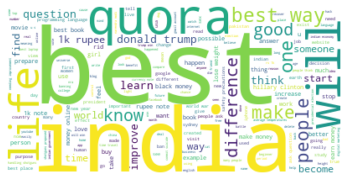

In [10]:
wc= WordCloud(background_color ='white', stopwords = STOPWORDS, max_words=len(textp_w)).generate(textp_w)
print('word cloud for  duplicate questions : ')


plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


* Word Cloud generated from Non Dulicate Questions :

word cloud for  duplicate questions : 


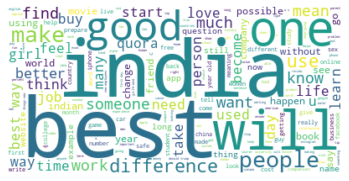

In [11]:
wc= WordCloud(background_color ='white', stopwords = stopwords, max_words=len(textn_w)).generate(textn_w)
print('word cloud for  duplicate questions : ')


plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h3> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h3>

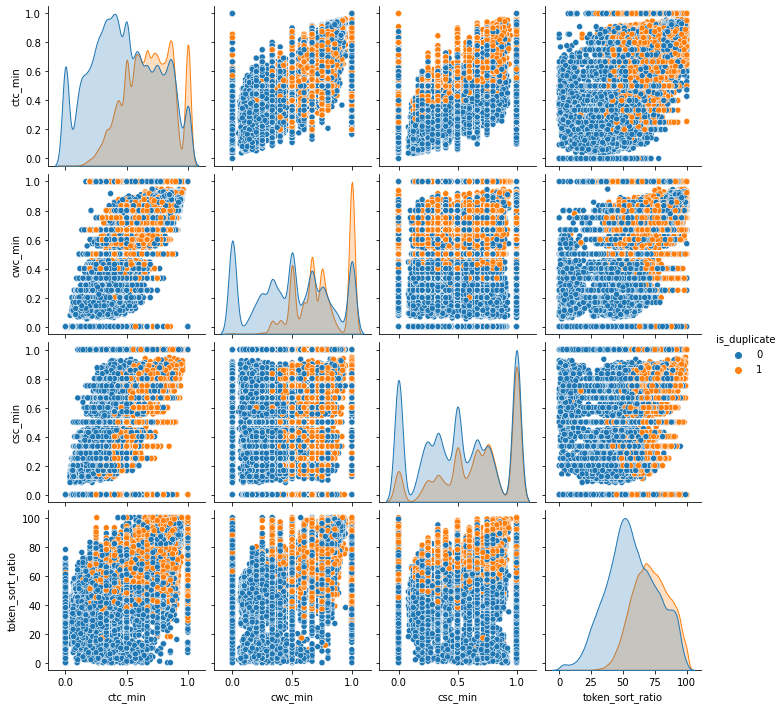

In [12]:
n=df.shape[0]
sn.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n],   hue='is_duplicate' , vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

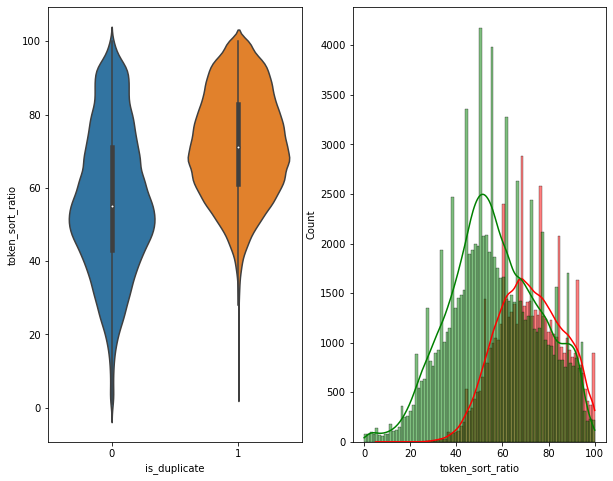

In [13]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
sn.violinplot(x='is_duplicate', y='token_sort_ratio', data=df[0:])

plt.subplot(1,2,2)
sn.histplot(df[df['is_duplicate']==1]['token_sort_ratio'][0:], label='1', color='red',  kde=True)
sn.histplot(df[df['is_duplicate']==0]['token_sort_ratio'][0:], label='0', color='green' , kde=True)


plt.show()

In [14]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 2 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled =  df[0:5000]

x=MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'token_fuzz_ratio' , 'token_fuzz_partial_ratio' , 'longest_substr_ratio']])

y=dfp_subsampled['is_duplicate'].values


In [15]:
from sklearn.manifold import TSNE

tsne2d = TSNE (n_components=2,init='random', perplexity=30., method= 'barnes_hut' , n_iter=1000 , verbose=2 , angle=0.5).fit_transform(x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.044s...
[t-SNE] Computed neighbors for 5000 samples in 0.787s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130390
[t-SNE] Computed conditional probabilities in 0.434s
[t-SNE] Iteration 50: error = 87.6632080, gradient norm = 0.0805391 (50 iterations in 5.794s)
[t-SNE] Iteration 100: error = 71.1965790, gradient norm = 0.0139267 (50 iterations in 3.183s)
[t-SNE] Iteration 150: error = 68.9553680, gradient norm = 0.0078289 (50 iterations in 3.297s)
[t-SNE] Iteration 200: error = 68.0367432, gradient norm = 0.0056138 (50 iterations in 4.493s)
[t-SNE] Iteration 250: error = 67.5316772, gradient norm = 0.0042566

C:\Users\welcome\anaconda3\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


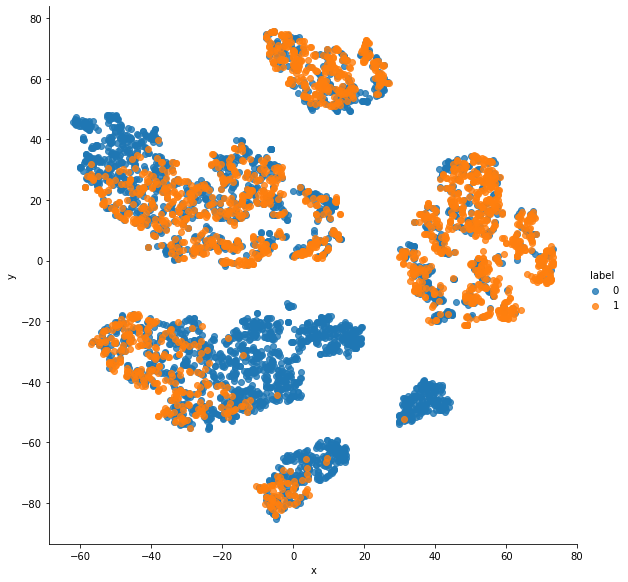

In [16]:
df=pd.DataFrame({'x':tsne2d[:,0],  'y':tsne2d[:,1], 'label':y })

sn.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False , size=8 )

plt.show()